# IMDB-CNN-SIGMOD

아래의 내용을 실행하고 나타난 결과입니다
[0.679717543706894, 0.8784799999809265]

1. 실제 데이터에 대한 상세 기술 
 - IMDB(인터넷 영화 데이터베이스)의 데이터에서 제공한 데이터들 중 양극단(긍정적,부정적) 리뷰의 단어들의 데이터셋입니다.
 - 훈련 데이터로는 2만 5000개의 데이터와 같은 수의 테스트 데이터로 구성되어 있으며 훈련 데이터를 2만개와 검증 데이터 5천개로 나누어 진행할    것입니다.
 - 데이터의 내용은 빈도수가 가장 높은 5000개 단어들로 구성하였습니다.

In [3]:
#imdb에서 제공하는 데이터를 가져온는 과정
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.utils.np_utils import to_categorical
import numpy as np

max_features = 5000
text_max_words = 200

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_features)

Using TensorFlow backend.


In [4]:
#가져온 데이터의 갯수 파악
print("트레이닝 데이터 :", len(train_data))
print("테스트 데이터 :", len(test_data))

트레이닝 데이터 : 25000
테스트 데이터 : 25000


In [5]:
# 데이터 내용을 확인하기 위하여 index를 매핑시킬 수 있는 딕셔너리 생성
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 첫번째 데이터에 있는 문자 확인과 이 내용이 긍정적인지 부정적인지 같은 인덱스에 존재하는 레이블을 이용하여 확인
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[9]])

if train_labels[9] == 1 :
    print("긍정적인 내용")
else:
    print("부정적인 내용")
decoded_review

부정적인 내용


"? this movie has many problem associated with it that makes it come off like a low budget class project from someone in film school i have to give it credit on its ? though many times throughout the movie i found myself laughing ? it was so bad at times that it was comical which made it a fun watch br br if you're looking for a low grade slasher movie with a twist of psychological horror and a ? of campy ? then pop a ? of popcorn ? some friends over and have some fun br br i agree with other comments that the sound is very bad dialog is next to impossible to follow much of the time and the soundtrack is kind of just there"

2. 예측하고자 하는 방법/방향 기술 
 - 특정한 단어의 집합으로 이루어진 양극단 데이터를 학습시킨 모델에 데이터를 입력할 때에 그 데이터가 긍정인지 부정인지 예측하기위하여 진행    하였습니다.

In [4]:
#5. 생성된 모델의 model.summary() 출력
x_val = train_data[:20000]
partial_x_train = train_data[20000:]

y_val = train_labels[:20000]
partial_y_train = train_labels[20000:]

In [5]:
# 데이터를 벡터로 변환
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
partial_x_train = sequence.pad_sequences(partial_x_train, maxlen=text_max_words)
x_test = sequence.pad_sequences(test_data, maxlen=text_max_words)

# 레이블의 자료형을 변경하여 불필요한 데이터 손실이 없게 변환
#y_train = np.asarray(y_val).astype('float32')
#partial_x_train = np.asarray(partial_y_train).astype('float32')
#y_test = np.asarray(test_labels).astype('float32')

3. 학습을 위해 데이터가 어떻게 가공/처리되었는지 기술 
 - 각 데이터마다 길이가 상이하므로 같은 길이로 맞추어 모델의 입력으로 사용하기 위해서 데이터 길이의 크기를 200으로 변경하였습니다.
   (모든 단어를 같은 길이로 맞춰주는 이유는 모델에서 데이터를 사용하기 위해서는 고정된 길이로 만들어줘야 하기 때문입니다.)
 - CNN모델에서 실수형을 쓰면 에러가 발생하기 때문에 레이블에 대한 데이터는 따로 가공하지 않았습니다. 

4. 사용된 모델의 특징에 대한 기술 
 - 이번 모델에서 사용한 레이어 중 중점인 레이어는 Conv1D입니다.
 - CNN은 기존의 Fully Connected를 형식을 가지고 있지만 특정 데이터일 경우 손실이 발생합니다. 이러한 단점을 보    완하하기 위한 모델입니다. 
 - CNN은 위의 언급처럼 데이터의 형상을 유지할 수 있으며, 이미지의 공간 정보를 유지하면서 인접 이미지와의 특징    을 효과적으로 인식이 가능합니다.

In [6]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=text_max_words))
#DropOut은 거대한 망에서 투표를 하여 노드를 줄여주는 역할을 하는데 거대한 망에서 오버피팅 되는것을 방지할 수 있음
#0.2 가중치만을 사용
model.add(Dropout(0.2))
#입력받을 데이터가 1차원이기 때문에 Conv1D를 사용
#256종류의 마스크와 3의 커널을 이용
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
#학습되는 문맥을 보면서 특징되는 문맥을 뽑아주는 역할
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
#각 층마다 사용되는 파라미터의 값과 구성이 어떻게 되었는지 간단하게 알 수 있음
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          640000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 256)          98560     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total para

In [10]:
#epoch은 최소 25회 이상 진행 
hist = model.fit(x_val, y_val, epochs=25, batch_size=256, validation_data=(partial_x_train, partial_y_train))

Train on 20000 samples, validate on 5000 samples
Epoch 1/25
20000/20000 [==============================] - 547s 27ms/step - loss: 0.5986 - acc: 0.6657 - val_loss: 0.4079 - val_acc: 0.8168
Epoch 2/25
20000/20000 [==============================] - 585s 29ms/step - loss: 0.3233 - acc: 0.8606 - val_loss: 0.2968 - val_acc: 0.8722
Epoch 3/25
20000/20000 [==============================] - 585s 29ms/step - loss: 0.2128 - acc: 0.9168 - val_loss: 0.2862 - val_acc: 0.8784
Epoch 4/25
20000/20000 [==============================] - 572s 29ms/step - loss: 0.1394 - acc: 0.9520 - val_loss: 0.2870 - val_acc: 0.8870
Epoch 5/25
20000/20000 [==============================] - 580s 29ms/step - loss: 0.0836 - acc: 0.9755 - val_loss: 0.3367 - val_acc: 0.8772
Epoch 6/25
20000/20000 [==============================] - 580s 29ms/step - loss: 0.0466 - acc: 0.9890 - val_loss: 0.3546 - val_acc: 0.8820
Epoch 7/25
20000/20000 [==============================] - 580s 29ms/step - loss: 0.0232 - acc: 0.9963 - val_loss: 0.3

In [16]:
import matplotlib.pyplot as plt

#그림으로 표현하기 위해서 history 데이터를 분리
history_dict = hist.history

acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

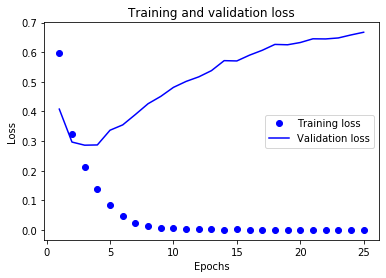

In [17]:

#손실을 그래프로 표시
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

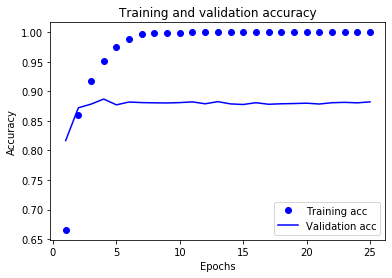

In [18]:
# 그래프를 초기화
plt.clf()  
#정확도를 그래프로 표시
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, test_labels, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

25000/25000 [==============================] - 14s 545us/step
## evaluation loss and_metrics ##
[0.679717543706894, 0.8784799999809265]


# CNN 종료